<a href="https://colab.research.google.com/github/et169tkm/jobawong-classify/blob/master/jobawong_classify_infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports { vertical-output: true, display-mode: "both" }

import math
import numpy as np
import pandas as pd
import os
import re
import scipy
import skimage.measure
import tensorflow as tf
import time
import tqdm # progress bar library
from matplotlib import pyplot as plt
from scipy.io.wavfile import read as wav_read

# plt.rcParams["figure.figsize"] = [16, 6] # graph size (inch, default 100 dpi)

INPUT_DIR = '/tmp/labelled_data/jobawong_2020-08-06L_22050'
MODEL_PATH = '/tmp/2020-08-06_%d.h5'

# How many models to train
# We can train many models with the same parameters and data and choose a good one
NUM_MODELS = 10

# How much of data as validation set
VALIDATION_RATIO = 0.2
# If more than half of the signal has abaolute value lower than this, drop the frame
NOISE_REMOVAL_THRESHOLD = 0.15
# List of all labels, the index/label mapping will be part of the trained model
CATEGORIES = ['s', 'k', 'm', 'j', 'o']
# Number of sample to fit in each FFT transofrm, has to be power of 2. Set to close to 10% of the sampling rate
NFFT = 2048
# Number of fbanks after preprocessing
NFILT = 240

BATCH_SIZE = 120

FILE_PATH = "/tmp/jobawong-classify"
FILE_PATH_FORMAT_SAMMY = FILE_PATH + "/s-%04d.wav"
FILE_PATH_FORMAT_KITTY = FILE_PATH + "/k-%04d.wav"
FILE_PATH_FORMAT_MARCO = FILE_PATH + "/m-%04d.wav"


# global variable for manual testing
sammy_frames = []
kitty_frames = []
marco_frames = []

In [ ]:
#@title Copy files { vertical-output: true, display-mode: "form" }

# load_data3() format

# Copy from google drive
print("mounting google drive")
from google.colab import drive
drive.mount('/tmp/gdrive')

%cp -r '/tmp/gdrive/My Drive/tensorflow/jobawong-classify/labelled_data_voice' '/tmp/labelled_data'


mounting google drive
Mounted at /tmp/gdrive


In [ ]:
#@title Function { vertical-output: true, display-mode: "code" }

def generate_sine_wave(array_length, sample_rate, freq):
  return np.sin(np.linspace(0, freq * array_length/sample_rate * math.pi*2, array_length)).tolist()

def load_file_as_signal(file_path):
  """Returns the sampling rate and a 1-D numpy array that contains the signals"""
  return wav_read(file_path)

def add_noise(signal, noise_max_amplitude=0.05):
  noise = np.random.rand(len(signal)) * noise_max_amplitude
  return noise + signal

def preemphasis(signal):
  # not sure what this does, copied from this:
  # https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
  PRE_EMPHASIS = 0.97
  return np.append(signal[0], signal[1:] - PRE_EMPHASIS * signal[:-1])

# Split the signals to multiple frames of length nfft
# if the signal can't fit to frames perfectly, the last frame is padded with zeroes
def split_to_frames_by_nfft(signal, nfft):
  if len(signal) == 0:
    return np.empty((0, nfft))
  frame_count = int(np.ceil(len(signal)/nfft))

  padded_signal = np.zeros(frame_count * nfft)
  padded_signal[0:signal.shape[0]] = signal
  frames = np.array(np.split(padded_signal, frame_count))
  return frames

def remove_silence_from_signal(signal, sampling_rate):
  SILENCE_THRESHOLD = 3000 # assuming the input is 16bit signed (-32768 - 32767)
  MAX_CONTINOUS_SILENT_SAMPLE_COUNT = sampling_rate * 0.1 # silence longer than 0.1 seconds will be removed
  if len(signal) == 0:
    return signal

  mask = [True] * len(signal)
  #print("debug ericlog: remove_silence_from_signal()1 %d %d" % (len(signal), len(mask)))

  # trim leading silence
  for i in range(len(signal)):
    if abs(signal[i]) >= SILENCE_THRESHOLD:
      mask[:i] = [False] * i
      break

  # filter the silence in 
  first_silent_index_of_this_chunk = -1 if abs(signal[0]) >= SILENCE_THRESHOLD else 0
  for i in range(len(signal)):
    if abs(signal[i]) < SILENCE_THRESHOLD:
      # mark beginning of silence
      if first_silent_index_of_this_chunk == -1:
        first_silent_index_of_this_chunk = i
    else: # silence is broken
      if first_silent_index_of_this_chunk != -1: # we were in a silent chunk
        if (i - first_silent_index_of_this_chunk) >= MAX_CONTINOUS_SILENT_SAMPLE_COUNT:
          # remove this chunk of silence
          mask[first_silent_index_of_this_chunk:i] = [False] * (i - first_silent_index_of_this_chunk)
        first_silent_index_of_this_chunk = -1 # reset this for next chunk of silence
  if first_silent_index_of_this_chunk != -1:
    # silence is not broken till the end of the signal, 
    # don't bother to check the length because we want to remove trailing silence
    mask[first_silent_index_of_this_chunk:] = [False] * (len(signal) - first_silent_index_of_this_chunk)
  
  signal_without_silence = signal[mask]
  #print("remove_silence_from_signal() before: %d, after: %d" % (len(signal), len(signal_without_silence)))
  return signal_without_silence

def remove_silent_frames(frames):
  mask = [False] * frames.shape[0]
  for i in range(frames.shape[0]):
    mask[i] = (np.percentile(np.abs(frames[i]), 50) > 0.0) and (np.amax(frames[i]) >= NOISE_REMOVAL_THRESHOLD)
  return frames[np.array(mask)]

def hamming(frames):
  hamming_frames = np.zeros(frames.shape)
  for i in range(frames.shape[0]):
    hamming_frames[i] = frames[i] * np.hamming(frames.shape[1])
  return hamming_frames

def fft(frames):
  # From doc: If n is even, the length of the transformed axis is (n/2)+1. If n is odd, the length is (n+1)/2.
  post_fft_length = frames.shape[1]//2 + (1 - (frames.shape[1] % 2)) 
  fft_frames = np.zeros((frames.shape[0], post_fft_length))
  for i in range(frames.shape[0]):
    # rfftn generates a list of imaginary numbers (wtf?)
    # Take absolute to get the magnitude (FFT outputs complex numbers, take absolute to get the combined magnitude of real and imaginary parts).
    # Then normalize by the size of the frame, because longer frame will cause higher magnitude just because more of the wave overlap
    # fft_frames.append(np.absolute(np.fft.rfft(frame)) / len(frame))
    frame = frames[i]
    fft_frames[i] = np.absolute(np.fft.rfft(frame)) / len(frame)
  return fft_frames

def frequency_spectrum_to_power_spectrum(frames, nfft):
  return frames ** 2

def power_spectrum_to_fbanks(power_frames, sample_rate, nfft, nfilt=26):
  # Adapted from https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
  low_freq_mel = 0
  high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
  mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
  hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
  bin = np.floor((nfft + 1) * hz_points / sample_rate)

  fbank = np.zeros((nfilt, int(np.floor(nfft / 2 + 1))))
  for m in range(1, nfilt + 1):
      f_m_minus = int(bin[m - 1])   # left
      f_m = int(bin[m])             # center
      f_m_plus = int(bin[m + 1])    # right

      for k in range(f_m_minus, f_m):
          fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
      for k in range(f_m, f_m_plus): 
          fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

  filter_banks = np.zeros((power_frames.shape[0], nfilt))
  #for power_frame in power_frames:
  for i in range(power_frames.shape[0]):
    power_frame = power_frames[i]
    frame_filter_banks = np.dot(power_frame, fbank.T)
    frame_filter_banks = np.where(frame_filter_banks == 0, np.finfo(float).eps, frame_filter_banks)  # Numerical Stability
    frame_filter_banks = 20 * np.log10(frame_filter_banks)  # dB
    filter_banks[i] = frame_filter_banks
  return filter_banks

def preprocess_frames(sampling_rate, frames, should_remove_silence=True):
  if len(frames) == 0:
    return np.empty(shape=(0, NFILT))

  # drop the frame if the label isn't "silent"
  if should_remove_silence:
    frames = remove_silent_frames(frames)

  return transform_frames(sampling_rate, frames)

def transform_frames(sampling_rate, frames):
  frames = hamming(frames)
  # print("len(frames[0]): %d" % len(frames[0]))
  # plot(frames[0], "frames[0] hamming")
  
  fft_frames = fft(frames)
  # print("len(fft_frames[0]): %d" % len(fft_frames[0]))
  # print("fft_frames[0] head: %s" % fft_frames[0][:40])
  # plot(np.array(fft_frames)[:,:256].T, "fft_frames (high freq truncated)(count: %d)" % len(fft_frames))

  power_frames = frequency_spectrum_to_power_spectrum(fft_frames, nfft=NFFT)
  # plot2d(np.array(power_frames)[:,:256], "power_frames (high freq truncated)(count: %d)" % len(power_frames))

  fbanks = power_spectrum_to_fbanks(power_frames, sample_rate=sampling_rate, nfft=NFFT, nfilt=NFILT)
  # plot2d(fbanks, "fbank")

  # fbanks is a 2d array, where the first dimension is time and the 2nd dimension is the fbanks
  # dct along the fbank axis (dct() default use the last axis)
  # mfcc = scipy.fft.dct(np.array(fbanks))
  # print(mfcc.shape)
  # plot2d(mfcc[:,:12], "mfcc[0:12]")
  # plot2d(mfcc[:,1:13], "mfcc[1:13]")
  # plot2d(mfcc[:,2:14], "mfcc[2:14]")
  # plot2d(mfcc[:,3:15], "mfcc[3:15]")

  # ret_value = fft_frames
  ret_value = fbanks
  return ret_value

def load_and_preprocess_one_file(each_file):
  f = open("%s/%s.txt" % (dir, each_file), 'r')
  lines = f.readlines()
  f.close()

  # load all data in this file into file_data
  file_data = {}
  sampling_rate, file_signal = load_file_as_signal("%s/%s.wav" % (dir, each_file))
  line_pattern = re.compile("(\d+)\s+(\d+)\s+(\w+)\s*(.*)")
  for line in tqdm.tqdm(lines):
    match = line_pattern.match(line)
    if not match:
      continue
    start = int(match.group(1))
    end = int(match.group(2))
    combined_label_string = match.group(3).lower()
      
    if combined_label_string not in file_data:
      file_data[combined_label_string] = np.empty(shape=(0, NFILT)) # 0 by NFFT array
    
    signal = file_signal[start:end]
    # remove silence if this sample is not for silence
    should_remove_silence = combined_label_string != '0' and combined_label_string != ''
    if should_remove_silence:
      signal = remove_silence_from_signal(signal, sampling_rate)
    frames = preprocess_frames(sampling_rate, split_to_frames_by_nfft(signal, nfft=NFFT), should_remove_silence)
    file_data[combined_label_string] = np.append(file_data[combined_label_string], frames, 0)
  return file_data
  

def balance_data(in_data, filter_ratios):
  out_data = {}
  for combined_label_string in in_data:
    # determine the ratio
    if combined_label_string not in filter_ratios:
      out_data[combined_label_string] = in_data[combined_label_string]
      continue

    ratio = filter_ratios[combined_label_string]
    periodicity = 20
    mask = [(i % periodicity) < (ratio * periodicity) for i in range(len(in_data[combined_label_string]))]
    data_of_this_label = in_data[combined_label_string]
    out_data[combined_label_string] = data_of_this_label[mask]
  return out_data


def label_string_to_categorical(label_string):
  label = np.array([0] * len(CATEGORIES))
  for i in range(len(CATEGORIES)):
    if CATEGORIES[i] in label_string:
      label[i] = 1
  return label

def categorical_to_label_string(categories):
  threshold = 0.5
  label_string = ""
  for i in range(len(CATEGORIES)):
    if categories[i] >= threshold:
      label_string = "%s%s" % (label_string, CATEGORIES[i])
  return label_string

def plot(data, title=None):
  if title:
    plt.title(title)
  plt.plot(data)
  plt.show()

def plot2d(data, title=None):
  fig, ax = plt.subplots()
  x = np.array([i for i in range(0,len(data)+1)])
  y = np.array([i for i in range(0,len(data[0])+1)])
  print("amin: %d, amax: %d" % (np.amin(data), np.amax(data)))
  if title:
    ax.set_title(title)
  ax.pcolormesh(x, y, np.array(data).T, cmap='rainbow')
  plt.show()

def plot_history(history, title='', xlabel='', ylabel='', fields_to_plot=[]):
  for field in fields_to_plot:
    plt.plot(history.history[field])
  plt.title(title)
  plt.ylabel(xlabel)
  plt.xlabel(ylabel)
  plt.ylim(ymin=0.0)
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [ ]:
#@title Copy label files again { vertical-output: true, display-mode: "both" }
%cp '/tmp/gdrive/My Drive/tensorflow/jobawong-classify/labelled_data_voice/jobawong_2020-08-06L_22050.txt' '/tmp/labelled_data/'
%cp '/tmp/gdrive/My Drive/tensorflow/jobawong-classify/labelled_data_voice/jobawong_2021-02-09L_22050.txt' '/tmp/labelled_data/'


cp: '/tmp/gdrive/My Drive/tensorflow/jobawong-classify/labelled_data_voice/jobawong_2020-08-06L_22050.txt' and '/tmp/labelled_data/jobawong_2020-08-06L_22050.txt' are the same file
cp: '/tmp/gdrive/My Drive/tensorflow/jobawong-classify/labelled_data_voice/jobawong_2021-02-09L_22050.txt' and '/tmp/labelled_data/jobawong_2021-02-09L_22050.txt' are the same file


In [ ]:
#@title Load and preprocess data 0 - define file list { vertical-output: true, display-mode: "both" }

dir = '/tmp/labelled_data'
file_list = [
    {'file': 'jobawong_2020-08-06L_22050',
    'filter_ratio': {
        'o': 0.13
    }},
    {'file': 'jobawong_2021-02-09L_22050',
    'filter_ratio': {
        's': 1,
        'k': 1,
        'm': 0,
        'j': 0.05,
        'o': 0.05,
    }},
    {'file': 'jobawong_2021-07-29_Kitty_Marco_L_22050',
     'filter_ratio': {}
    },
    {'file': 'librispeech',
    'filter_ratio': {
        'o': 1 ,
    }},
    {"file": "jingles_hit_hot_hong_kong", "filter_ratio": {"j": 0.1}},
    {"file": "jingles_its_a_反", "filter_ratio": {"j": 0.1}},
    # {"file": "jingles_夾夾甲", "filter_ratio": {"j": 0.1}},
    {"file": "jingles_歌之詩", "filter_ratio": {"j": 0.1}},
    # {"file": "jingles_霸王領隊", "filter_ratio": {"j": 0.1}},
    # {"file": "jingles_霸王知己_mimi龍虎榜_又係問呢啲", "filter_ratio": {"j": 0.1}},
    # {"file": "jingles_霸王老人院", "filter_ratio": {"j": 0.1}},
    # {"file": "jingles_你知道唔知道", "filter_ratio": {"j": 0.1}},
    # {"file": "jingles_霸王我最喜愛全球華人勁爆金曲至尊歌", "filter_ratio": {"j": 0.1}},
  ]

In [ ]:
#@title Load and preprocess data 1 - preprocess { vertical-output: true, display-mode: "both" }

## Load and preprocess files, keep data separate per-file per-label
data_per_file_per_label = {}
for each_file_and_filter_ratios in file_list:
  each_file = each_file_and_filter_ratios['file']
  file_data = load_and_preprocess_one_file(each_file)
  data_per_file_per_label[each_file] = file_data


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


In [ ]:
#@title Load and preprocess data 2 - select data { vertical-output: false, display-mode: "code" }

# Separate data of each label into training and validation data and then shuffle
# Because adjacent frames can be highly correlated, so if one two adjacent
# frames ended in training data and the other one ended in validation data.
# Memorizing the training data will cause really low validation loss too, which
# make the validation data not useful.
def separate_and_shuffle_data(data):
  global NFILT
  column_names_x = ["x%d" % i for i in range(NFILT)]
  column_names_label = ["label_%s" % c for c in CATEGORIES]
  column_names_data_set = ["is_training", "is_validation"]
  df = pd.DataFrame([], columns=(column_names_x + column_names_label + column_names_data_set))

  training_data = np.empty(shape=(0, NFILT))
  training_multilabels = np.empty(shape=(0, len(CATEGORIES)))
  validation_data = np.empty(shape=(0, NFILT))
  validation_multilabels = np.empty(shape=(0, len(CATEGORIES)))
  for combined_label_string in data:
    label = label_string_to_categorical(combined_label_string)
    frames_of_this_label = data[combined_label_string]
    validation_cutoff = int(VALIDATION_RATIO * len(frames_of_this_label))

    if combined_label_string == "j":
      ### Backup
      # use all data as training data because different part of the the data
      # are different samples, they don't generalize to each other
      v = frames_of_this_label[:1]
      t = frames_of_this_label[:]
      ### END backup

      # Use all data as both training validation data because we just want it to
      # memorize it.
      v = frames_of_this_label[:]
      t = frames_of_this_label[:]
    else:  
      v = frames_of_this_label[:validation_cutoff]
      t = frames_of_this_label[validation_cutoff:]
    df = add_to_data_frame(df, t, v, column_names_label, label)
    print("label: %s, validation data count: %d, training data count: %d" % (label, len(v), len(t)))

    validation_data = np.append(validation_data, v, axis=0)
    validation_multilabels = np.append(validation_multilabels, np.repeat([label], len(v), axis=0), axis=0)
    training_data = np.append(training_data, t, axis=0)
    training_multilabels = np.append(training_multilabels, np.repeat([label], len(t), axis=0), axis=0)
  return (training_data, training_multilabels, validation_data, validation_multilabels, df)

def add_to_data_frame(df, t, v, column_names_label, label):
  df_v = pd.DataFrame(v, columns=["x%d" % i for i in range(NFILT)])
  for i in range(len(CATEGORIES)):
    df_v[column_names_label[i]] = label[i]
  df_v['is_training'] = False
  df_v['is_validation'] = True
  
  df_t = pd.DataFrame(t, columns=["x%d" % i for i in range(NFILT)])
  for i in range(len(CATEGORIES)):
    df_t[column_names_label[i]] = label[i]
  df_t['is_training'] = True
  df_t['is_validation'] = False

  df = df.append(df_t, ignore_index=True)
  df = df.append(df_v, ignore_index=True)
  return df



# Balance the files in each file
balanced_data_per_file_per_label = {}
for each_file_and_filter_ratios in file_list:
  each_file = each_file_and_filter_ratios['file']
  each_file_filter_ratio = each_file_and_filter_ratios['filter_ratio'] if 'filter_ratio' in each_file_and_filter_ratios else {}

  balanced_data_per_file_per_label[each_file] = balance_data(data_per_file_per_label[each_file], each_file_filter_ratio)

# Join the data from different files
data = {}
for each_file_and_filter_ratios in file_list:
  each_file = each_file_and_filter_ratios['file']
  for combined_label_string in balanced_data_per_file_per_label[each_file]:
    if combined_label_string not in data:
      data[combined_label_string] = np.empty(shape=(0, NFILT)) # 0 by NFFT array
    data[combined_label_string] = np.append(data[combined_label_string], balanced_data_per_file_per_label[each_file][combined_label_string], 0)

# separate data of each label into training and validation data
training_and_validation_data_frame = None
(training_data, training_labels, validation_data, validation_labels, training_and_validation_data_frame) = separate_and_shuffle_data(data)

label: [1 0 0 0 0], validation data count: 1167, training data count: 4672
label: [0 1 0 0 0], validation data count: 1982, training data count: 7929
label: [0 0 1 0 0], validation data count: 2606, training data count: 10428
label: [1 1 0 0 0], validation data count: 84, training data count: 338
label: [1 0 1 0 0], validation data count: 63, training data count: 256
label: [0 1 1 0 0], validation data count: 49, training data count: 199
label: [1 1 1 0 0], validation data count: 9, training data count: 38
label: [0 0 0 0 0], validation data count: 387, training data count: 1548
label: [0 0 0 0 1], validation data count: 4895, training data count: 19584
label: [0 0 0 1 0], validation data count: 4892, training data count: 4892


In [ ]:
#@title pd data frame - Validate pd data frames { display-mode: "code" }

# Checks that the data in df is the same as training_data and validation_data
def validate_df(training_data, training_labels, validation_data, validation_labels, df):
  global NFILT
  global CATEGORIES

  print(training_data.shape)
  print(validation_data.shape)

  print(df[df["is_training"]].shape)
  print(df[df["is_validation"]].shape)

  for i in tqdm.tqdm(range(training_data.shape[0])):
    df_training = df[df["is_training"]].reset_index(drop=True)
    if not np.array_equal(
        training_data[i],
        df_training.loc[i,"x0":"x%d"%(NFILT-1)].array):
      print("training data different at i=%d" % i)
      break
    if not np.array_equal(
        training_labels[i],
        df_training.loc[i,"label_%s"%CATEGORIES[0]:"label_%s"%CATEGORIES[-1]].array):
      print("training label different at i=%d" % i)
      break
      
  for i in tqdm.tqdm(range(validation_data.shape[0])):
    df_validation = df[df["is_validation"]].reset_index(drop=True)
    if not np.array_equal(
        validation_data[i],
        df_validation.loc[i,"x0":"x%d"%(NFILT-1)].array):
      print("validation data different at i=%d" % i)
      break
    if not np.array_equal(
        validation_labels[i],
        df_validation.loc[i,"label_%s"%CATEGORIES[0]:"label_%s"%CATEGORIES[-1]].array):
      print("validation label different at i=%d" % i)
      break

validate_df(training_data, training_labels, validation_data, validation_labels, training_and_validation_data_frame)


(49884, 240)
(16134, 240)
(49884, 247)
(16134, 247)


100%|██████████| 16134/16134 [06:31<00:00, 41.16it/s]


In [ ]:
#@title pd data frame - export to csv and copy to drive { vertical-output: true, display-mode: "code" }

training_and_validation_data_frame.to_csv('/tmp/preprocessed.csv',index=False)
%cp '/tmp/preprocessed.csv' '/tmp/gdrive/My Drive/tensorflow/jobawong-classify/labelled_data_voice/format_v2/'



Training data len  : 49884
Validation data len: 16134
Training data len   :  (49884, 240)
Validation data len :  (16134, 240)
Training label len  :  (49884, 5)
Validation label len:  (16134, 5)
training_dataset len   : 49884
validation_dataset len : 16134
training_dataset  : <TensorSliceDataset element_spec=(TensorSpec(shape=(240,), dtype=tf.float64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>
validation_dataset: <TensorSliceDataset element_spec=(TensorSpec(shape=(240,), dtype=tf.float64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>
training_dataset len (batch)  : 416
validation_dataset len (batch): 505
training_dataset  : <BatchDataset element_spec=(TensorSpec(shape=(None, 240), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>
validation_dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 240), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>
NUM_CLASSES:

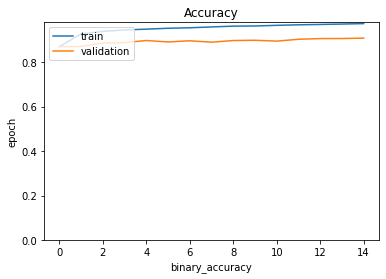

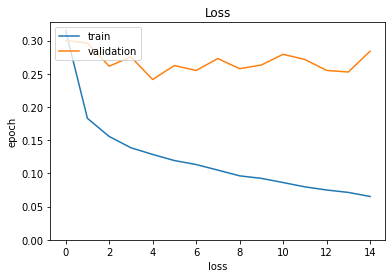

=== Training model: 1
Epoch 1/15
416/416 [==============================] - 8s 16ms/step - loss: 0.3108 - binary_accuracy: 0.8748 - categorical_accuracy: 0.6445 - val_loss: 0.3269 - val_binary_accuracy: 0.8724 - val_categorical_accuracy: 0.6463
Epoch 2/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1799 - binary_accuracy: 0.9296 - categorical_accuracy: 0.8011 - val_loss: 0.2815 - val_binary_accuracy: 0.8756 - val_categorical_accuracy: 0.6665
Epoch 3/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1522 - binary_accuracy: 0.9405 - categorical_accuracy: 0.8265 - val_loss: 0.2607 - val_binary_accuracy: 0.8920 - val_categorical_accuracy: 0.6968
Epoch 4/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1356 - binary_accuracy: 0.9471 - categorical_accuracy: 0.8440 - val_loss: 0.2430 - val_binary_accuracy: 0.8976 - val_categorical_accuracy: 0.7253
Epoch 5/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1243 - bi

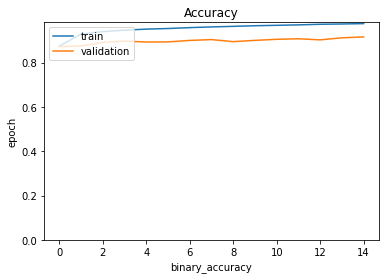

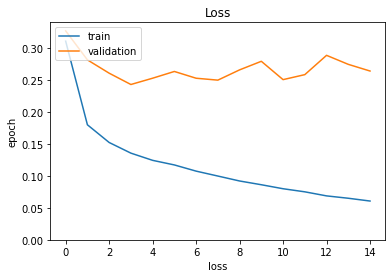

=== Training model: 2
Epoch 1/15
416/416 [==============================] - 8s 16ms/step - loss: 0.2946 - binary_accuracy: 0.8791 - categorical_accuracy: 0.6544 - val_loss: 0.3086 - val_binary_accuracy: 0.8734 - val_categorical_accuracy: 0.6436
Epoch 2/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1761 - binary_accuracy: 0.9313 - categorical_accuracy: 0.8038 - val_loss: 0.2840 - val_binary_accuracy: 0.8830 - val_categorical_accuracy: 0.6802
Epoch 3/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1517 - binary_accuracy: 0.9407 - categorical_accuracy: 0.8270 - val_loss: 0.2786 - val_binary_accuracy: 0.8865 - val_categorical_accuracy: 0.6849
Epoch 4/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1358 - binary_accuracy: 0.9471 - categorical_accuracy: 0.8437 - val_loss: 0.2703 - val_binary_accuracy: 0.8896 - val_categorical_accuracy: 0.6982
Epoch 5/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1242 - bi

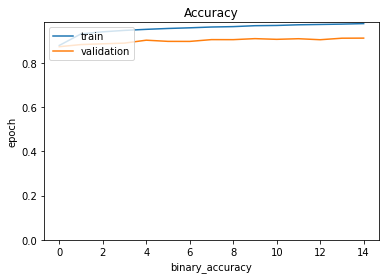

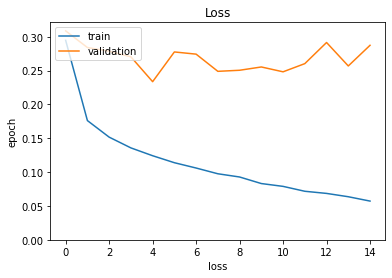

=== Training model: 3
Epoch 1/15
416/416 [==============================] - 8s 16ms/step - loss: 0.2763 - binary_accuracy: 0.8845 - categorical_accuracy: 0.6680 - val_loss: 0.2936 - val_binary_accuracy: 0.8791 - val_categorical_accuracy: 0.6635
Epoch 2/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1741 - binary_accuracy: 0.9311 - categorical_accuracy: 0.8025 - val_loss: 0.2659 - val_binary_accuracy: 0.8845 - val_categorical_accuracy: 0.6820
Epoch 3/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1473 - binary_accuracy: 0.9422 - categorical_accuracy: 0.8290 - val_loss: 0.2754 - val_binary_accuracy: 0.8839 - val_categorical_accuracy: 0.6832
Epoch 4/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1328 - binary_accuracy: 0.9482 - categorical_accuracy: 0.8439 - val_loss: 0.2521 - val_binary_accuracy: 0.8975 - val_categorical_accuracy: 0.7132
Epoch 5/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1207 - bi

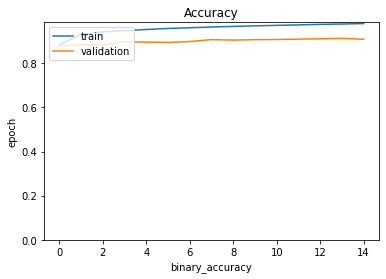

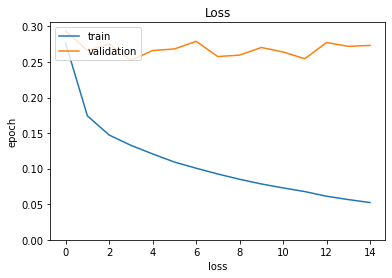

=== Training model: 4
Epoch 1/15
416/416 [==============================] - 8s 16ms/step - loss: 0.2869 - binary_accuracy: 0.8820 - categorical_accuracy: 0.6664 - val_loss: 0.3213 - val_binary_accuracy: 0.8657 - val_categorical_accuracy: 0.6403
Epoch 2/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1758 - binary_accuracy: 0.9316 - categorical_accuracy: 0.8082 - val_loss: 0.2558 - val_binary_accuracy: 0.8888 - val_categorical_accuracy: 0.6909
Epoch 3/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1483 - binary_accuracy: 0.9427 - categorical_accuracy: 0.8326 - val_loss: 0.2584 - val_binary_accuracy: 0.8934 - val_categorical_accuracy: 0.7037
Epoch 4/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1337 - binary_accuracy: 0.9486 - categorical_accuracy: 0.8485 - val_loss: 0.2512 - val_binary_accuracy: 0.8952 - val_categorical_accuracy: 0.7117
Epoch 5/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1246 - bi

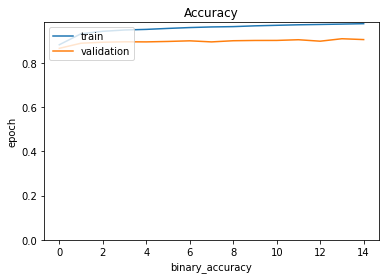

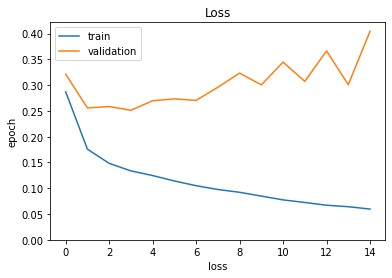

=== Training model: 5
Epoch 1/15
416/416 [==============================] - 8s 16ms/step - loss: 0.3077 - binary_accuracy: 0.8778 - categorical_accuracy: 0.6547 - val_loss: 0.3125 - val_binary_accuracy: 0.8695 - val_categorical_accuracy: 0.6389
Epoch 2/15
416/416 [==============================] - 7s 16ms/step - loss: 0.1789 - binary_accuracy: 0.9302 - categorical_accuracy: 0.7981 - val_loss: 0.2786 - val_binary_accuracy: 0.8811 - val_categorical_accuracy: 0.6659
Epoch 3/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1525 - binary_accuracy: 0.9403 - categorical_accuracy: 0.8248 - val_loss: 0.2817 - val_binary_accuracy: 0.8866 - val_categorical_accuracy: 0.6848
Epoch 4/15
416/416 [==============================] - 7s 16ms/step - loss: 0.1378 - binary_accuracy: 0.9461 - categorical_accuracy: 0.8395 - val_loss: 0.2530 - val_binary_accuracy: 0.8953 - val_categorical_accuracy: 0.7076
Epoch 5/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1277 - bi

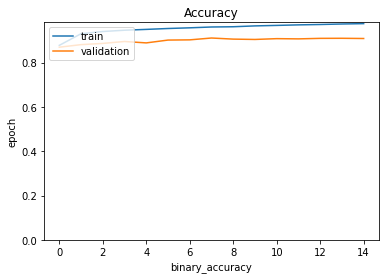

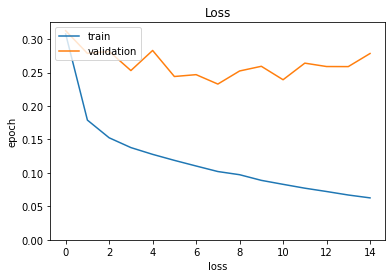

=== Training model: 6
Epoch 1/15
416/416 [==============================] - 9s 16ms/step - loss: 0.2832 - binary_accuracy: 0.8833 - categorical_accuracy: 0.6677 - val_loss: 0.2992 - val_binary_accuracy: 0.8695 - val_categorical_accuracy: 0.6458
Epoch 2/15
416/416 [==============================] - 7s 16ms/step - loss: 0.1776 - binary_accuracy: 0.9302 - categorical_accuracy: 0.8003 - val_loss: 0.2878 - val_binary_accuracy: 0.8844 - val_categorical_accuracy: 0.6750
Epoch 3/15
416/416 [==============================] - 7s 16ms/step - loss: 0.1513 - binary_accuracy: 0.9409 - categorical_accuracy: 0.8266 - val_loss: 0.2678 - val_binary_accuracy: 0.8865 - val_categorical_accuracy: 0.6825
Epoch 4/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1355 - binary_accuracy: 0.9477 - categorical_accuracy: 0.8435 - val_loss: 0.2514 - val_binary_accuracy: 0.8964 - val_categorical_accuracy: 0.7078
Epoch 5/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1241 - bi

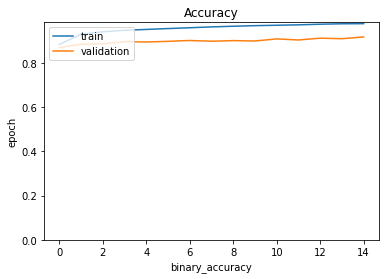

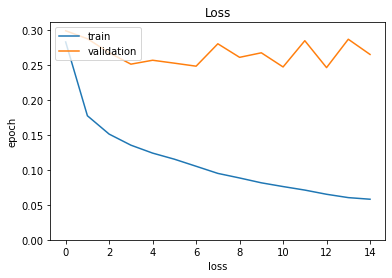

=== Training model: 7
Epoch 1/15
416/416 [==============================] - 8s 16ms/step - loss: 0.2914 - binary_accuracy: 0.8831 - categorical_accuracy: 0.6707 - val_loss: 0.3211 - val_binary_accuracy: 0.8624 - val_categorical_accuracy: 0.6231
Epoch 2/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1768 - binary_accuracy: 0.9314 - categorical_accuracy: 0.8052 - val_loss: 0.2805 - val_binary_accuracy: 0.8845 - val_categorical_accuracy: 0.6752
Epoch 3/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1540 - binary_accuracy: 0.9396 - categorical_accuracy: 0.8250 - val_loss: 0.2658 - val_binary_accuracy: 0.8897 - val_categorical_accuracy: 0.6881
Epoch 4/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1363 - binary_accuracy: 0.9469 - categorical_accuracy: 0.8452 - val_loss: 0.2674 - val_binary_accuracy: 0.8898 - val_categorical_accuracy: 0.7078
Epoch 5/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1260 - bi

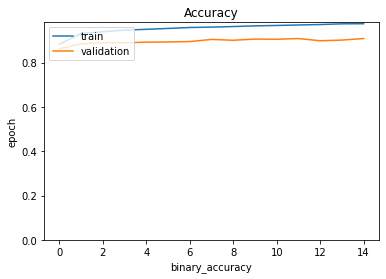

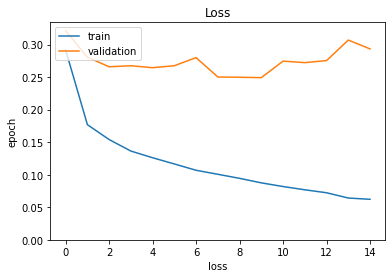

=== Training model: 8
Epoch 1/15
416/416 [==============================] - 8s 16ms/step - loss: 0.2935 - binary_accuracy: 0.8798 - categorical_accuracy: 0.6568 - val_loss: 0.3123 - val_binary_accuracy: 0.8747 - val_categorical_accuracy: 0.6406
Epoch 2/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1771 - binary_accuracy: 0.9307 - categorical_accuracy: 0.7996 - val_loss: 0.2810 - val_binary_accuracy: 0.8809 - val_categorical_accuracy: 0.6735
Epoch 3/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1503 - binary_accuracy: 0.9411 - categorical_accuracy: 0.8281 - val_loss: 0.2838 - val_binary_accuracy: 0.8855 - val_categorical_accuracy: 0.6828
Epoch 4/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1339 - binary_accuracy: 0.9475 - categorical_accuracy: 0.8437 - val_loss: 0.2674 - val_binary_accuracy: 0.8920 - val_categorical_accuracy: 0.7040
Epoch 5/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1249 - bi

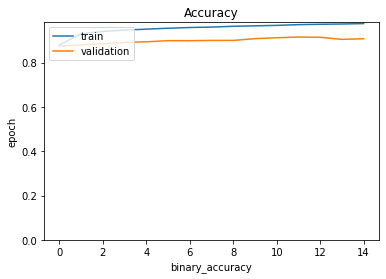

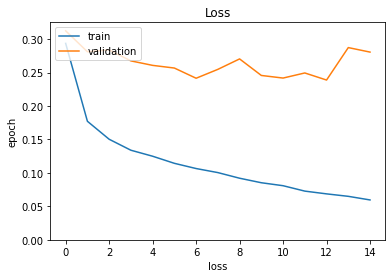

=== Training model: 9
Epoch 1/15
416/416 [==============================] - 8s 16ms/step - loss: 0.2875 - binary_accuracy: 0.8818 - categorical_accuracy: 0.6589 - val_loss: 0.2834 - val_binary_accuracy: 0.8763 - val_categorical_accuracy: 0.6530
Epoch 2/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1736 - binary_accuracy: 0.9313 - categorical_accuracy: 0.8024 - val_loss: 0.2679 - val_binary_accuracy: 0.8886 - val_categorical_accuracy: 0.6936
Epoch 3/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1455 - binary_accuracy: 0.9434 - categorical_accuracy: 0.8329 - val_loss: 0.2541 - val_binary_accuracy: 0.8940 - val_categorical_accuracy: 0.7033
Epoch 4/15
416/416 [==============================] - 7s 16ms/step - loss: 0.1306 - binary_accuracy: 0.9491 - categorical_accuracy: 0.8484 - val_loss: 0.2543 - val_binary_accuracy: 0.8954 - val_categorical_accuracy: 0.7275
Epoch 5/15
416/416 [==============================] - 6s 15ms/step - loss: 0.1203 - bi

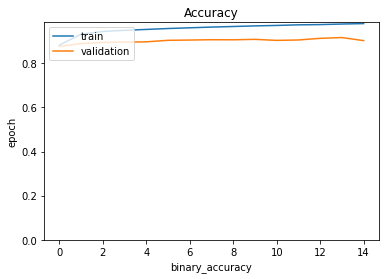

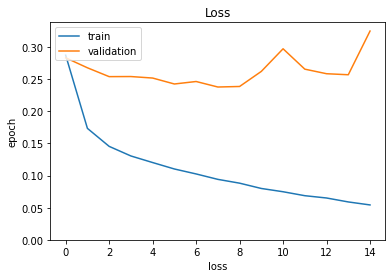

In [ ]:
#@title Train { display-mode: "code" }

def residual_block(x, filters, conv_num=3, activation="relu"):
    s = tf.keras.layers.Conv1D(filters, 1, padding="same")(x) # Shortcut

    for i in range(conv_num - 1):
        x = tf.keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = tf.keras.layers.Add()([x, s])
    x = tf.keras.layers.Activation(activation)(x)
    return tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(x)
  
def test1(training_data, training_labels, validation_data, validation_labels):
  print("Training data len  : %d" % len(training_data))
  print("Validation data len: %d" % len(validation_data))
  print("Training data len   : ", np.array(training_data).shape)
  print("Validation data len : ", np.array(validation_data).shape)
  print("Training label len  : ", np.array(training_labels).shape)
  print("Validation label len: ", np.array(validation_labels).shape)
  if len(training_data) == 0:
    print("No training data")
    return

  # convert to tf dataset
  training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
  validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))
  print("training_dataset len   : %d" % len(training_dataset))
  print("validation_dataset len : %d" % len(validation_dataset))
  print("training_dataset  : %s" % training_dataset)
  print("validation_dataset: %s" % validation_dataset)
  

  # Shuffle and sparate into batches
  # We split the data into training/validation data before shuffling, because
  # for a given audio signal, each data point (of a 0.1s window) is highly 
  # correlated to the next one. If we select data points randomly as validation
  # data, it's very likely a nearby data point is in the training data. We will
  # end up having very high validation accuracy just because the network 
  # memorized the nearby data point.
  training_dataset = training_dataset.shuffle(buffer_size=len(training_dataset), seed=0xb656cfa5).batch(BATCH_SIZE)
  validation_dataset = validation_dataset.shuffle(buffer_size=len(validation_dataset), seed=0xb656cfa5).batch(32)
  print("training_dataset len (batch)  : %d" % len(training_dataset))
  print("validation_dataset len (batch): %d" % len(validation_dataset))
  print("training_dataset  : %s" % training_dataset)
  print("validation_dataset: %s" % validation_dataset)


  # num_classes = np.amax(training_labels)+1
  num_classes = len(training_labels[0])
  print("NUM_CLASSES: %d" % num_classes)
  input_shape = (len(training_data[0]), 1)
  print("input_shape: ", input_shape)

  models = []
  for i in range(NUM_MODELS):
    # start build the network
    inputs = tf.keras.layers.Input(shape=input_shape, name="input")
    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = tf.keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)

    # outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output")(x) # sinble label
    outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid", name="output")(x) # multi label

    print("=== Training model: %d" % i)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    # model.summary()

    model.compile(
      # optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"] # single label
      optimizer="Adam", 
      loss="binary_crossentropy", 
      metrics=[
        "binary_accuracy", # check each element of the predicted vector
        "categorical_accuracy" # check if the element with the highest value in the predicted vector matches that of the labelled vector
      ]
    )

    history = model.fit(
        training_dataset, 
        epochs=15, 
        validation_data=validation_dataset,
        verbose=1 # 0:silent, 1: progress bar, 2: one line per epoch(default: 1)
        )
    models.append(model)

    plot_history(history, title="Accuracy", xlabel="epoch", ylabel="binary_accuracy", fields_to_plot=["binary_accuracy", "val_binary_accuracy"])
    plot_history(history, title="Loss", xlabel="epoch", ylabel="loss", fields_to_plot=["loss", "val_loss"])

  return models

test_models = test1(training_data, training_labels, validation_data, validation_labels)
for i in range(NUM_MODELS):
  test_models[i].save(MODEL_PATH % i)

In [ ]:
#@title Show model summary { vertical-output: false }
test_models[0].summary()

In [ ]:
#@title testing { vertical-output: true, display-mode: "code" }

# 2020-11-30 - categorical accuracy - s: 0.86-0.9, k: 0.68-0.73, m: 0.65-0.74 # jobawong_2020-08-06 1600 lines
# 2020-12-10 - categorical accuracy - s: 0.67-0.83, k: 0.66-0.75, m: 0.69-0.76 # jobawong_2020-08-06 1900 lines, batch size=120
# 2020-12-10 - categorical accuracy - s: 0.66-0.80, k: 0.64-0.78, m: 0.66.0.75 # jobawong_2020-08-06 1900 lines, batch size=480. Worse performance (average categorical accuracies are) than batch size 120, minor improvement on training time, lower training speed (in term of epocks).


def test_evaluate(model, label_string):
  one_preprocessed_input = np.array(global_validation_data_by_label_string[label_string][0:])
  one_label = np.tile(label_string_to_categorical(label_string), (len(one_preprocessed_input), 1))
  # print("label_string: %s, sample count: %d" % (label_string, one_preprocessed_input.shape[0]))
  return model.evaluate(
      one_preprocessed_input,
      one_label,
      verbose=0,
      return_dict=True)

def check_predictions(model, data, label):
  # check the false negative rate for each category predicted for each sample
  # 1 sample x 5 categories => maximum 5 false positive/false negative
  false_positive_count = 0
  false_negative_count = 0
  predictions = model.predict(data)
  for i in range(predictions.shape[0]):
    for j in range(predictions.shape[1]):
      predicted_v = predictions[i][j]
      labelled_v = label[j]
      if labelled_v != round(predicted_v):
        if labelled_v == 0:
          false_positive_count += 1
        else:
          false_negative_count += 1
  return (predictions, false_positive_count, false_negative_count)

# create a table of label and predictions
def create_label_prediction_matrix(model, data_by_label_string):
  label_prediction_matrix = {}
  for label_string in data_by_label_string:
    # initialize the map with all labels
    result_map = {}

    predictions = model.predict(data_by_label_string[label_string])
    for one_prediction in predictions:
      predicted_label_string = categorical_to_label_string(one_prediction)
      if predicted_label_string not in result_map:
        result_map[predicted_label_string] = 0
      result_map[predicted_label_string] += 1

    label_prediction_matrix[label_string] = result_map
  return label_prediction_matrix

def evaluate_model(model):
  for label_string in ['s', 'k', 'm', 'j', '0', 'o']:
    result = test_evaluate(model, label_string)
    print("%s,%.04f,%.04f,%.04f" % (
        label_string, 
        result['loss'], # binary cross entropy
        result['binary_accuracy'],
        result['categorical_accuracy']
        ))

for i in range(NUM_MODELS):
  print("Evaluating model: %d" % i)
  print("l,  loss,bin ac,cat ac")
  model = tf.keras.models.load_model(MODEL_PATH % i)
  evaluate_model(model)

# ## Manual testing
# print("\n\n")
# label_string = "sk" # "s", "k" ,"m", "j", ""
# print("Detail prediction data, label: \"%s\"" % label_string)
# # one_preprocessed_input = global_training_data_by_label_string[label_string][0:]
# one_preprocessed_input = global_validation_data_by_label_string[label_string][0:]
# one_label = np.tile(label_string_to_categorical(label_string), (len(one_preprocessed_input), 1))
# (predictions, false_positive_count, false_negative_count) = check_predictions(
#     model2, 
#     one_preprocessed_input, 
#     label_string_to_categorical(label_string))
# model2.evaluate(one_preprocessed_input, one_label)
# print("false +ve: %d, false -ve: %d, num prediction: %d = %d (samples) x %d (categories)" % 
#       (false_positive_count, false_negative_count, (predictions.shape[0] * predictions.shape[1]), predictions.shape[0], predictions.shape[1]))

# ## create matrix
# print(create_label_prediction_matrix(model2, global_validation_data_by_label_string))


Evaluating model: 0
l,  loss,bin ac,cat ac


NameError: ignored

(16134, 240)
(16134, 5)
(16134, 5)
    threshold  precision    recall
98       0.98   0.861214  0.525321
    threshold  precision    recall
96       0.96   0.854932  0.624294
    threshold  precision    recall
77       0.77   0.851336  0.537587
    threshold  precision    recall
24       0.24   0.851218  0.935609
    threshold  precision    recall
70        0.7   0.851329  0.529928
(16134, 240)
(16134, 5)
(16134, 5)
    threshold  precision    recall
96       0.96   0.852975  0.552532
    threshold  precision    recall
83       0.83   0.850943  0.637006
    threshold  precision    recall
79       0.79   0.852152  0.617162
    threshold  precision    recall
16       0.16   0.853877  0.954415
    threshold  precision    recall
81       0.81   0.852406  0.593463
(16134, 240)
(16134, 5)
(16134, 5)
    threshold  precision    recall
99       0.99   0.866557  0.397581
    threshold  precision    recall
91       0.91   0.851007  0.596987
    threshold  precision    recall
77       0.77   0.85

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
97       0.97   0.851765  0.547241


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
85       0.85   0.854643  0.597928


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
75       0.75   0.850838  0.558489


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
66       0.66   0.850516  0.925797


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
64       0.64   0.850194  0.492748
(16134, 240)
(16134, 5)
(16134, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
97       0.97   0.858173  0.539683


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
77       0.77   0.850522  0.613465


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
82       0.82   0.850226  0.482948


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
53       0.53   0.851002  0.955029


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
70        0.7   0.854056  0.492543
(16134, 240)
(16134, 5)
(16134, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
90        0.9   0.852868  0.517007


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
91       0.91   0.850172  0.582392


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision   recall
85       0.85    0.85224  0.53722


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
40        0.4   0.850506  0.961774


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
66       0.66   0.850448  0.582022
(16134, 240)
(16134, 5)
(16134, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
94       0.94   0.857651  0.546485


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
93       0.93   0.855949  0.626648


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
71       0.71    0.85181  0.552255


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
34       0.34   0.850504  0.931521


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
83       0.83   0.852971  0.519101
(16134, 240)
(16134, 5)
(16134, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
99       0.99   0.874465  0.463341


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
67       0.67   0.852543  0.623352


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
70        0.7   0.853228  0.513751


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
18       0.18   0.852795  0.945012


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
89       0.89     0.8542  0.542186
(16134, 240)
(16134, 5)
(16134, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision   recall
97       0.97    0.86087  0.52381


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
91       0.91   0.851972  0.620527


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
77       0.77   0.853792  0.573891


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
78       0.78   0.850178  0.926819


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


    threshold  precision    recall
69       0.69   0.851174  0.436977


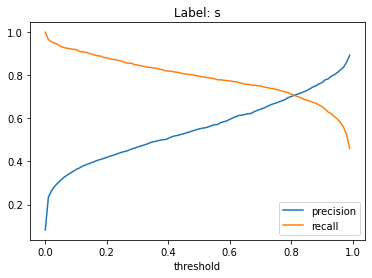

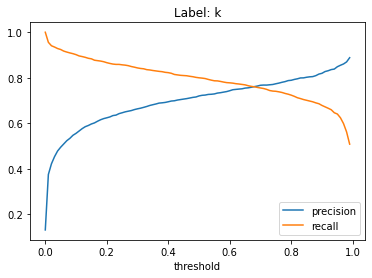

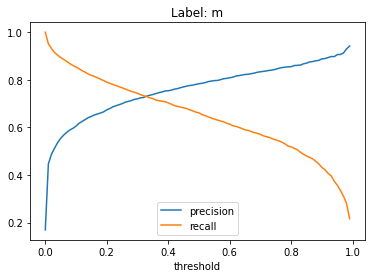

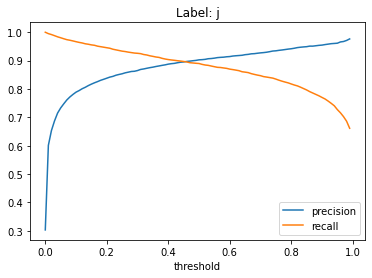

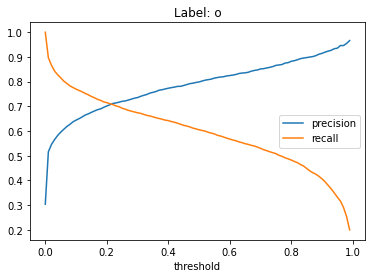

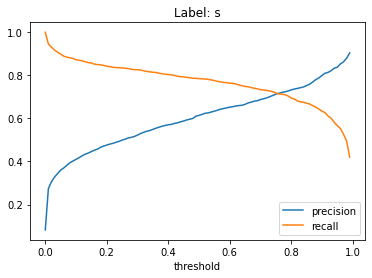

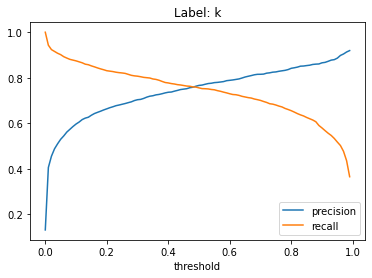

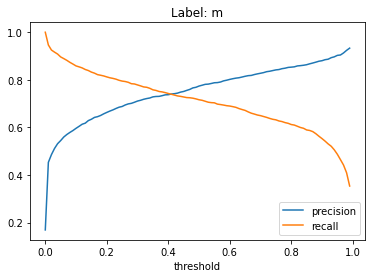

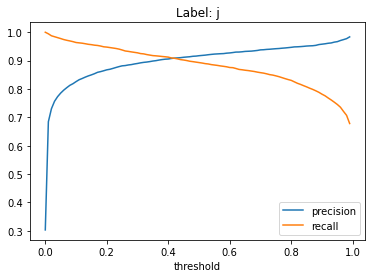

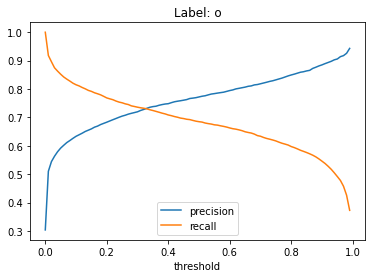

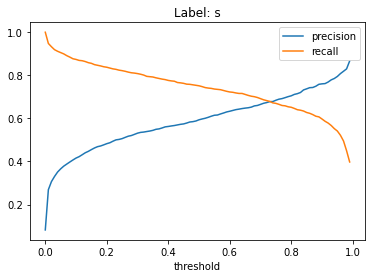

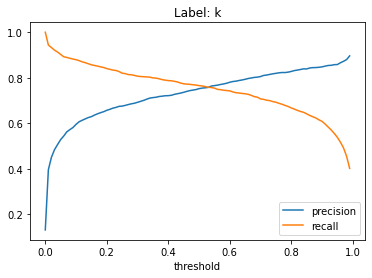

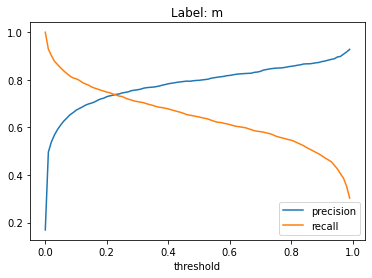

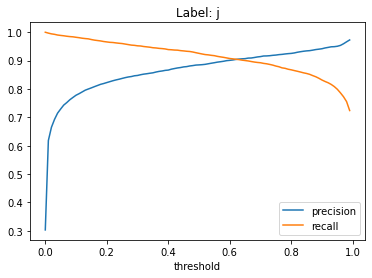

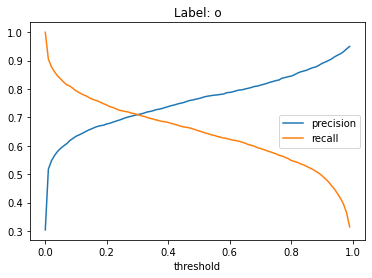

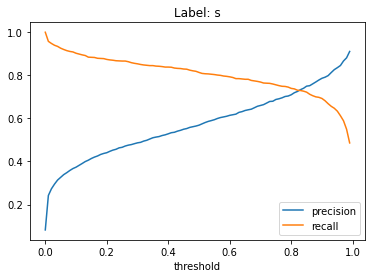

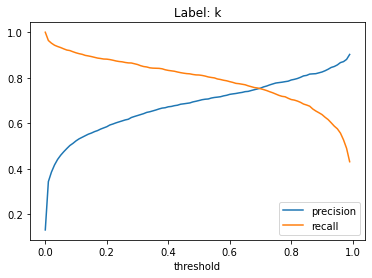

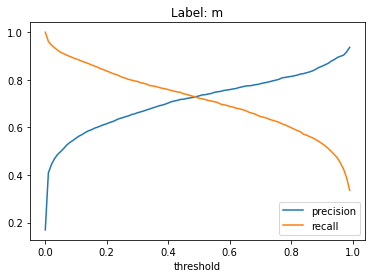

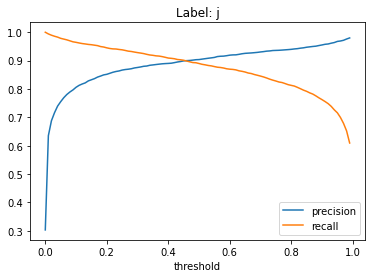

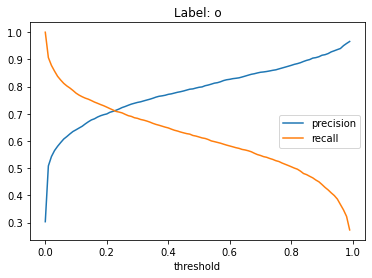

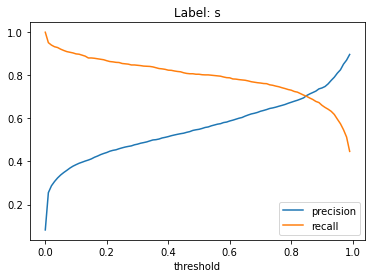

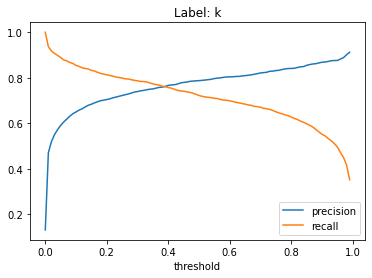

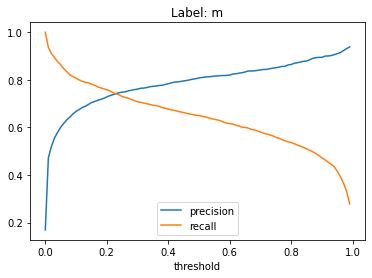

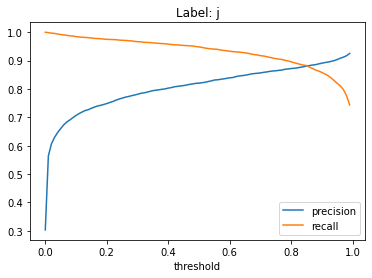

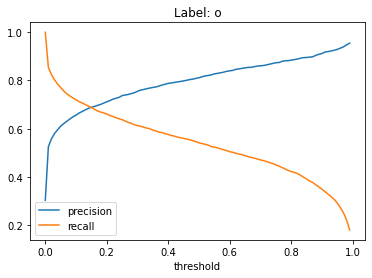

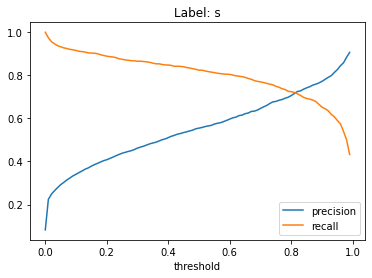

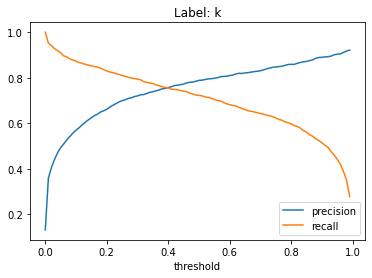

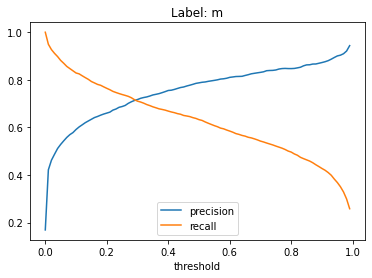

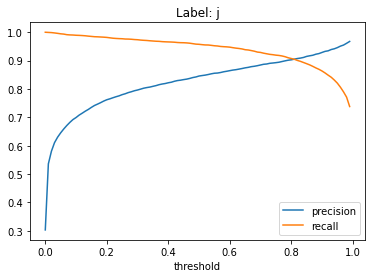

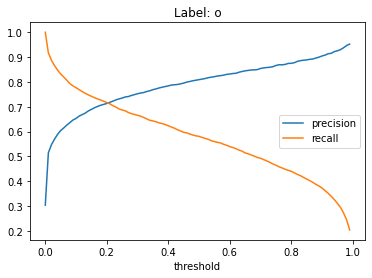

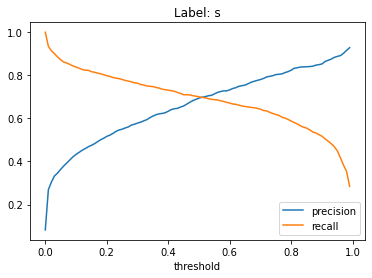

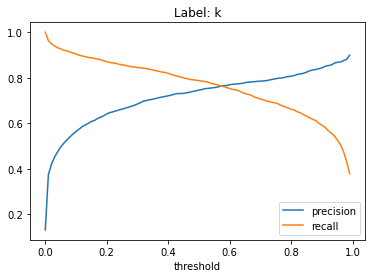

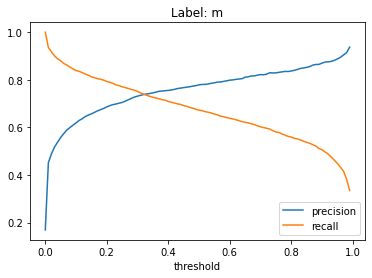

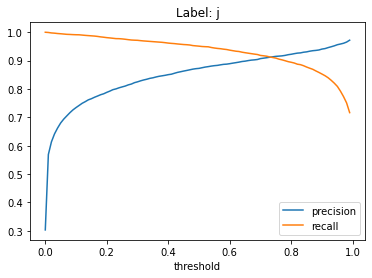

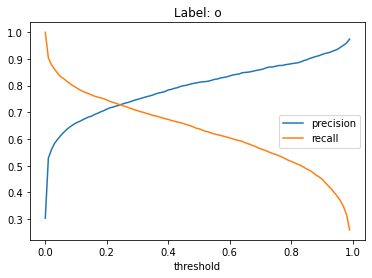

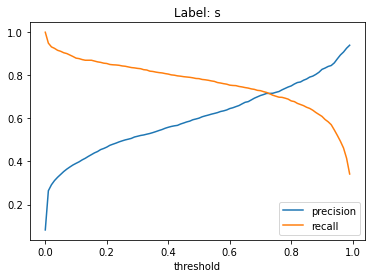

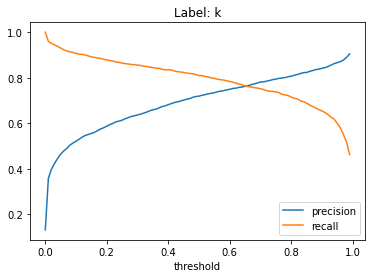

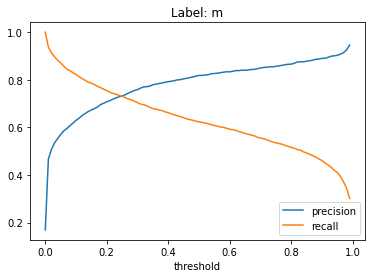

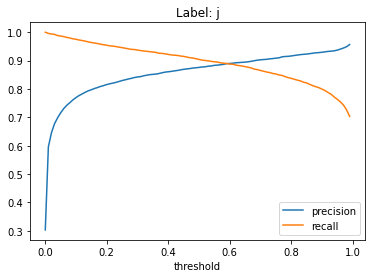

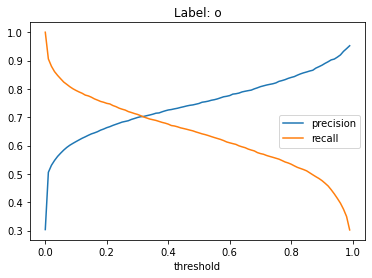

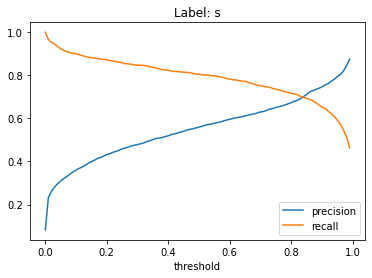

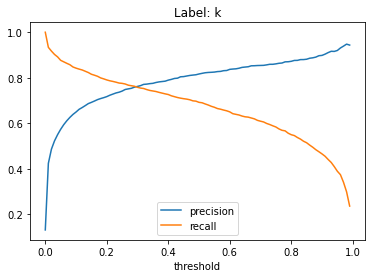

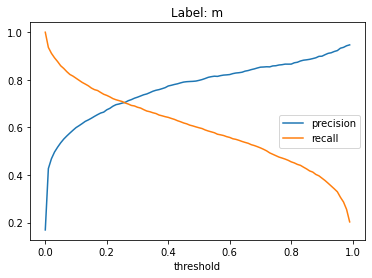

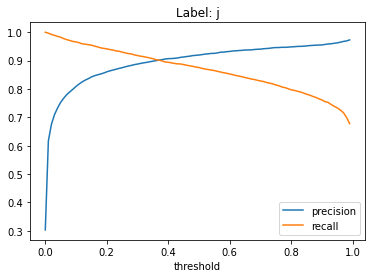

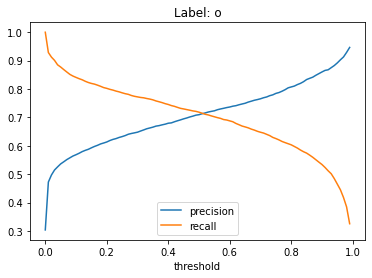

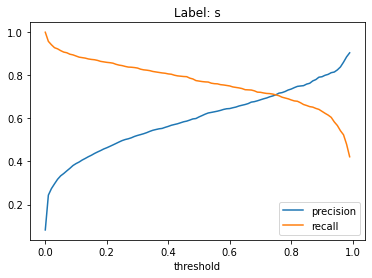

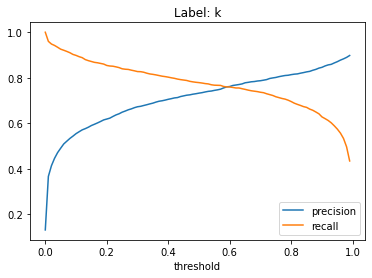

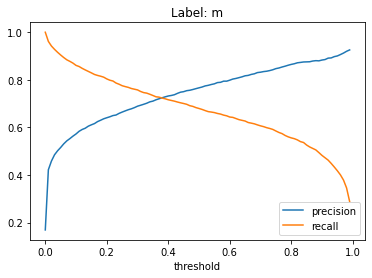

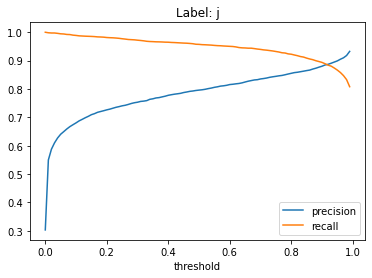

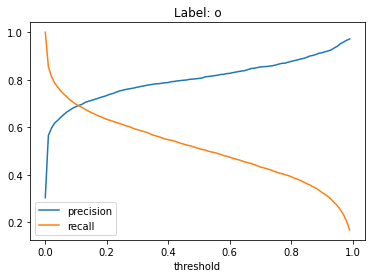

In [ ]:
#@title Precision and recall of validation data  { vertical-output: false, display-mode: "code" }

def calculate_precision_recall(models, validation_data, validation_labels):
  global CATEGORIES
  
  models_thresholds = [] # thresholds for all models
  for model in models:
    prediction = model.predict(validation_data)
    print(validation_data.shape)
    print(validation_labels.shape)
    print(prediction.shape)

    df_labels = pd.DataFrame(validation_labels, columns=["label_%s" % c for c in CATEGORIES])
    df_prediction = pd.DataFrame(prediction, columns=["predicted_label_%s" % c for c in CATEGORIES])

    df = pd.DataFrame(df_prediction)
    df[["label_%s" % c for c in CATEGORIES]] = df_labels
    single_model_thresholds = [] # thresholds for this model
    for c in CATEGORIES:
      df_precision_recall = pd.DataFrame([], columns=[ "threshold", "precision", "recall"])
      for i in range(100):
        threshold = i/100

        predicted_positive_count = df.loc[df["predicted_label_%s" % c] > threshold].shape[0]
        actual_positive_count = df.loc[df["label_%s" % c] > threshold].shape[0]
        true_positive_count = df.loc[(df["label_%s" % c] > 0.5) & (df["predicted_label_%s" % c] > threshold)].shape[0]

        new_row = pd.DataFrame(
            [[threshold, (true_positive_count/predicted_positive_count), (true_positive_count/actual_positive_count)]],
            columns=df_precision_recall.columns)
        df_precision_recall = df_precision_recall.append(new_row, ignore_index=True)
        
      # Plot precision/recall graph
      df_precision_recall.plot.line(x="threshold", y=["precision","recall"], title="Label: %s" % c)

      # print the threshold of a given recall/precision criteria
      # row = df_precision_recall.loc[df_precision_recall["precision"] > df_precision_recall["recall"]][:1] # when precision is just higher than recall
      row = df_precision_recall.loc[df_precision_recall["precision"] > 0.85][:1] # when precision > 0.9
      print(row)
      single_model_thresholds.append(row.iloc[0].loc["threshold"])
    models_thresholds.append(single_model_thresholds)
  return models_thresholds

models_thresholds = calculate_precision_recall(test_models, validation_data, validation_labels)


In [ ]:
#@title inference - load and preproces{ vertical-output: true, display-mode: "code" }

def inference_load_and_preprocess():
  t0 = time.time()
  # shell script that re-sample and split channel to a wav file:
  # ffmpeg -i sunnyday_2021-02-09.m4a -sample_fmt s16 -map_channel 0.0.0 -ar 22050 sunnyday_2021-02-09L_22050.wav
  # %cp -r '/tmp/gdrive/MyDrive/tensorflow/jobawong-classify/labelled_data_voice/jobawong_2021-03-15L_22050.wav' '/tmp/test_inference.wav'
  %cp -r '/tmp/gdrive/MyDrive/tensorflow/jobawong-classify/labelled_data_voice/jobawong_2021-01-18L_22050.wav' '/tmp/test_inference.wav'
  # %cp -r '/tmp/gdrive/MyDrive/tensorflow/jobawong-classify/labelled_data_voice/jobawong_2021-07-29_Kitty_Marco_L_22050.wav' '/tmp/test_inference.wav'
  print("time - copying from google drive: %.2fs" % (time.time() - t0))

  t0 = time.time()
  sampling_rate, signal = load_file_as_signal('/tmp/test_inference.wav')
  if sampling_rate != 22050:
    # just to remind myself
    print("The smpling rate is not 22050 (got %d)!!" % sampling_rate)
    sys.exit(1)
  should_remove_silence = False
  frames = preprocess_frames(sampling_rate, split_to_frames_by_nfft(signal, nfft=NFFT), should_remove_silence)
  print("time - loading data and preprocessing: %.2fs" % (time.time() - t0))
  return frames


inference_frames = inference_load_and_preprocess()

print(inference_frames.shape)

time - copying from google drive: 5.53s
time - loading data and preprocessing: 24.10s
(74807, 240)


In [ ]:
#@title inference - infer and threshold{ vertical-output: true, display-mode: "code" }

def inference_infer(model, frames):
  raw_prediction = model.predict(frames)
  return raw_prediction

def threshold_inference(raw_prediction, threaholds):
  # Transform each sample to 1 or 0 on each label according to the threshold
  transformed_prediction = np.apply_along_axis(lambda row : [(1 if row[i] > threaholds[i] else 0) for i in range(len(threaholds))], 
                             1,
                             raw_prediction)
  return transformed_prediction

model_index = 0
raw_predictions = inference_infer(test_models[model_index], inference_frames)
print(raw_predictions.shape)
np.savetxt('/tmp/prediction_raw.csv', raw_predictions, delimiter=',')

thresholded_prediction = threshold_inference(raw_predictions, models_thresholds[model_index])
print(thresholded_prediction.shape)
np.savetxt('/tmp/prediction_thresholded.csv', thresholded_prediction, delimiter=',')


(74807, 5)
(74807, 5)


In [ ]:
#@title inference - save prediction as wav { vertical-output: true, display-mode: "code" }

from scipy.io.wavfile import write as wav_write

def save_prediction_as_wav(path, predictions):
  wav_write(path, 22050, np.array(predictions, dtype=np.float32))

# save_prediction_as_wav('/tmp/prediction_raw.wav', raw_predictions)
save_prediction_as_wav('/tmp/prediction_transformed.wav', thresholded_prediction)

predictions_avgpooled.shape:  (7481, 5)
predictions_avgpooled_trimmed.shape:  (7481, 5)


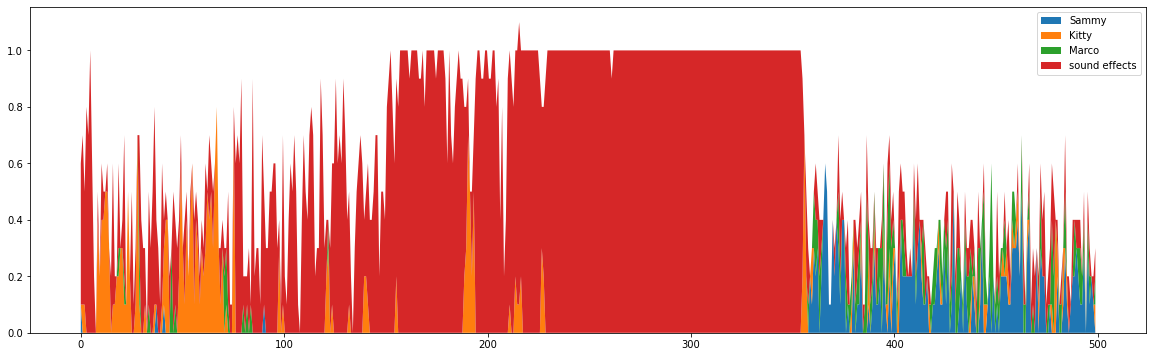

In [ ]:
#@title inference - result visualization

#test_models[i].save('/tmp/model_2_2021-02-09.h5')

def inference_visualize(predictions, sampling_rate, nfft, downsampling_ratio, start, end):
  predictions_avgpooled = skimage.measure.block_reduce(predictions, (downsampling_ratio, 1), np.mean)
  end = min(end, len(predictions_avgpooled))

  predictions_avgpooled_trimmed = predictions_avgpooled[start:end]
  print("predictions_avgpooled.shape: ", predictions_avgpooled.shape)
  print("predictions_avgpooled_trimmed.shape: ", predictions_avgpooled.shape)

  old_figsize = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = [20, 6] # this is global
  plt.stackplot(
      # [i for i in range(start, end)],
      [i*2048*DOWN_SAMPLE_RATIO/22050 for i in range(start, end)],
      predictions_avgpooled_trimmed.transpose()[:4][:], # remove the data for "others"
      labels = ["Sammy", "Kitty", "Marco", "sound effects"],
      )
  plt.rcParams["figure.figsize"] = old_figsize
  plt.legend(loc='upper right')

DOWN_SAMPLE_RATIO = 10
t0 = 0
t1 = t0+500
i0 = int(t0*22050/2048/DOWN_SAMPLE_RATIO) # index of the first data to be plotted (inclusive)
i1 = int(t1*22050/2048/DOWN_SAMPLE_RATIO) # index of the last data to be plotted (exclusive)
# inference_visualize(raw_predictions, 22050, 2048, DOWN_SAMPLE_RATIO, i0, i1)
inference_visualize(thresholded_prediction, 22050, 2048, DOWN_SAMPLE_RATIO, i0, i1)